# PHXS 491_001: Observational Astronomy - Exam 2

### Due Tuesday, Nov 9, 2021
Remember to save your completed notebook as a PDF and upload both ipynb/PDF to Brightspace/D2L under Assignments.

Name: William Jardee

## Please use the "primt()" function (notice the "m") to print out your answers in magenta.  This makes grading easier.  You might need to "print to PDF" to get the colors to show up.

In [1]:
def primt(*args):
    '''
    For any amount of arguments "*args", prints in magenta.
    '''
    magenta = "\x1B[38;5;201m"   # the color in ANSI code
    string = ""
    for el in args:  # for each argument
        string += " "+(str(el))  # add the argument to the string to be printed
    magenta += string[1:]
    print(magenta)   #print!

In [2]:
# Theme control for convenience
import jupyterthemes as jt
!jt -t grade3 -T -N -kl -nfs 11 -fs 11 -ofs 11 -cursc r -cellw 90%
# jt.jtplot.style()
jt.get_themes()

['chesterish',
 'grade3',
 'gruvboxd',
 'gruvboxl',
 'monokai',
 'oceans16',
 'onedork',
 'solarizedd',
 'solarizedl']

In [3]:
import os
import numpy as np
from glob import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from astropy.stats import SigmaClip, sigma_clipped_stats, mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.io import fits
from astropy.table import Table
import scipy.stats as stats
from photutils import Background2D, MedianBackground
from bozepy import ccdproc
import matplotlib as mpl

# %matplotlib notebook
%matplotlib inline

In [4]:
path = "data/"

Make sure you have the ``exam2_data.zip`` file.

## 1) CCD image calibration:

Use ``masterbias()`` from ``bozepy.ccdproc`` and the 10 provided bias images to create a master bias frame.

In [5]:
out=ccdproc.ccdlist(f'{path}*.fit')

Bias-0001  3468  2728  Bias Frame  0.001000000047497  None
Bias-0002  3468  2728  Bias Frame  0.001000000047497  None
Bias-0003  3468  2728  Bias Frame  0.001000000047497  None
Bias-0004  3468  2728  Bias Frame  0.001000000047497  None
Bias-0005  3468  2728  Bias Frame  0.001000000047497  None
Bias-0006  3468  2728  Bias Frame  0.001000000047497  None
Bias-0007  3468  2728  Bias Frame  0.001000000047497  None
Bias-0008  3468  2728  Bias Frame  0.001000000047497  None
Bias-0009  3468  2728  Bias Frame  0.001000000047497  None
Bias-0010  3468  2728  Bias Frame  0.001000000047497  None
DoubleCluster-0003B  3468  2728  Light Frame  120.0  Blue
DoubleCluster-0003R  3468  2728  Light Frame  120.0  Red
DoubleCluster-0023B  3468  2728  Light Frame  30.0  Green
master_bias  3388  2712  Bias Frame  0.001000000047497  None
master_dark  3388  2712  Dark Frame  60.0  None
master_flat  3388  2712  Flat Field  10.0  Red


In [6]:
biases = np.where("Bias Frame" == out['imagetyp'])
bias_list = out[biases]['file']

# accounts for not deleting the last master bias, otherwise it tries to change bias with the previous master and breaks
if f'{path}master_bias.fit'.replace("/", "\\") in bias_list: bias_list = bias_list[:-1]
im, head = ccdproc.masterbias(files=bias_list, outfile=f"{path}master_bias.fit", clobber=True)

## 2) CCD image reduction:

Use your master bias image and the provided master dark and flat images to reduce the three science ``DoubleCluster`` exposures with the ``ccdproc()`` function in the ``bozepy.ccdproc`` module.

In [7]:
sci = np.where("Light Frame" == out['imagetyp'])
sci_list = out[sci]['file']

im, head = ccdproc.ccdproc(sci_list, zero=f"{path}master_bias.fit", dark=f"{path}master_dark.fit", flat=f"{path}master_flat.fit",
                            outfile=True, verbose=True, outsuffix="_proc", clobber=True)

Loading data\DoubleCluster-0003B.fit
Sat Nov 13 13:04:19 2021 Overscan is [1:41,1:2728] and [3430:3465,1:2728], mean 958.2760882812214
Sat Nov 13 13:04:19 2021 Trimming to [42:3429,15:2726]
Sat Nov 13 13:04:19 2021 ZERO: mean   0.20, stdev   8.56
Sat Nov 13 13:04:20 2021 DARK: mean   2.00, stdev  14.73
Sat Nov 13 13:04:20 2021 FLAT: mean   1.00, stdev   0.05
Sat Nov 13 13:04:20 2021 CCD processing done
Writing processed file to data/DoubleCluster-0003B_proc.fits
Loading data\DoubleCluster-0003B.fit
Sat Nov 13 13:04:21 2021 Overscan is [1:41,1:2728] and [3430:3465,1:2728], mean 958.7815058841459
Sat Nov 13 13:04:21 2021 Trimming to [42:3429,15:2726]
Sat Nov 13 13:04:21 2021 ZERO: mean   0.20, stdev   8.56
Sat Nov 13 13:04:21 2021 DARK: mean   2.00, stdev  14.73
Sat Nov 13 13:04:21 2021 FLAT: mean   1.00, stdev   0.05
Sat Nov 13 13:04:21 2021 CCD processing done
Writing processed file to data/DoubleCluster-0003R_proc.fits
Loading data\DoubleCluster-0003B.fit
Sat Nov 13 13:04:22 2021 Over

## 3) Calculating centroids and sigma with moments:

a) Calculate the X/Y centroids of the star near X=785 and Y=780 in image ``DoubleCluster-0003B.fit`` using the first moment.  Remember that you need to subtract a median background value from your image "thumbnail".

b) Display the 2D image thumbnail and overplot your centroid position to check that it is reasonable.

c) Calculate the sigma/spread of the star using the second moment.  

d) Make cross-section plots (along the central column and then along the central row) and overplot your centroid positions (as a vertical line) and make a horiztonal line for your sigma values (converted to FWHM = 2.35*sigma).

In [8]:
imB, headB = fits.getdata(f'{path}DoubleCluster-0003B_proc.fits',0,header=True)
imR, headR = fits.getdata(f'{path}DoubleCluster-0003R_proc.fits',0,header=True)

In [9]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(imB, (200, 200), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
# # Subtract the background
sim = imB - bkg.background

im2 = sim[760:795, 770:805].copy()
im2[im2<0] = 0
ny,nx = im2.shape
xx,yy = np.meshgrid(np.arange(nx)+770,np.arange(ny)+ 760)
mnx = np.sum(im2*xx) / np.sum(im2)
print(mnx)
mny = np.sum(im2*yy) / np.sum(im2)
print(mny)

786.6988655584667
776.6714183628218


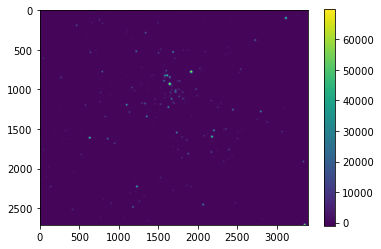

In [10]:
plt.imshow(sim)
plt.colorbar()
plt.show()

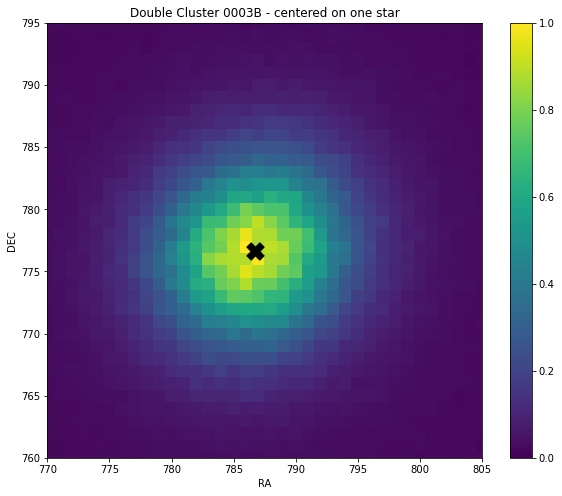

In [11]:
plt.figure(figsize=(10,8))
plt.imshow(imB, vmin=-100, vmax=50000)
plt.scatter([mnx],[mny],c='black',marker='X',s=300)
plt.xlim(770, 805)
plt.ylim(760, 795)
plt.title("Double Cluster 0003B - centered on one star")
plt.xlabel('RA')
plt.ylabel("DEC")
plt.colorbar()
plt.show()

In [12]:
(770-805)/2
(760-795)/2

-17.5

sigma x: 5.69
sigma y: 5.72


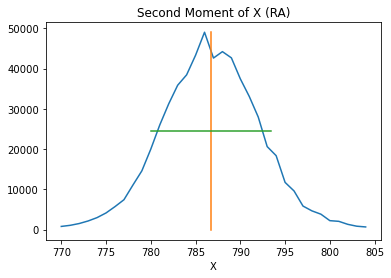

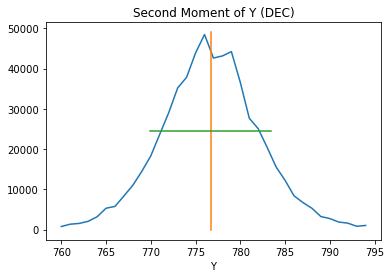

In [13]:
sigx2 = np.sum(im2*(xx-mnx)**2) / np.sum(im2)
sigx = np.sqrt(sigx2)
primt(f"sigma x: {sigx:.2f}")

sigy2 = np.sum(im2*(yy-mny)**2) / np.sum(im2)
sigy = np.sqrt(sigy2)
primt(f"sigma y: {sigy:.2f}")

maxflx = np.max(im2)

x = np.arange(nx)+770
plt.plot(x,im2[17,:])
plt.plot([mnx,mnx],[-100,maxflx])
plt.plot([-sigx*2.35/2+mnx,sigx*2.35/2+mnx],[0.5*maxflx,0.5*maxflx])
plt.xlabel('X')
plt.title("Second Moment of X (RA)")
plt.show()

y = np.arange(ny)+760
plt.plot(y,im2[:,17])
plt.plot([mny,mny],[-100,maxflx])
plt.plot([-sigy*2.35/2+mny,sigy*2.35/2+mny],[0.5*maxflx,0.5*maxflx])
plt.xlabel('Y')
plt.title("Second Moment of Y (DEC)")
plt.show()

## 4) Background estimation and subtraction

a) Use the photutils ``Background2D`` to estimate the background for images ``DoubleCluster-0003B.fit`` and ``DoubleCluster-0003R.fit`` using a 250x250 box size for estimating the statistics.  Plot the background model for one of them.

In [14]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkgB = Background2D(imB, (250, 250), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

bkgR = Background2D(imR, (250, 250), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

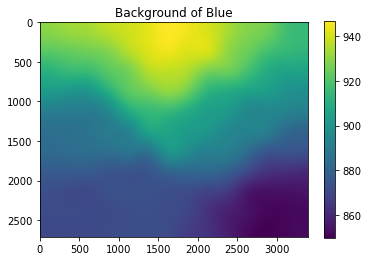

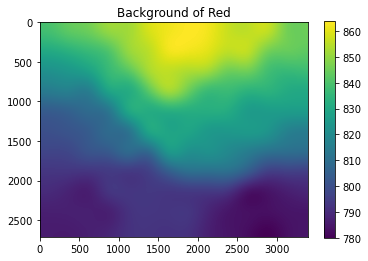

In [15]:
plt.imshow(bkgB.background)
plt.colorbar()
plt.title("Background of Blue")
plt.show()

plt.imshow(bkgR.background)
plt.colorbar()
plt.title("Background of Red")
plt.show()

b) Subtract the background from the images and put it in a new variable, e.g. ``subim``.

In [16]:
# Subtract the background
subimB = imB - bkgB.background
subimR = imR - bkgR.background

## 5) Detection

a) Use the photutils ``DAOStarFinder`` detection routine to perform detection on the two background-subtracted images.  For the FWHM, use the sigma value (converted to FWHM) you calculated above for the star in ``DoubleCluster-0003B.fit``.  Set the threshold at 5 standard deviations above the background value (which you need to calculate first).

In [17]:
from photutils import DAOStarFinder
mean, median, std = sigma_clipped_stats(subimB, sigma=3.0)
daofind = DAOStarFinder(fwhm=17.5, threshold=5.*std)  
sourcesB = daofind(subimB) 

mean, median, std = sigma_clipped_stats(subimR, sigma=3.0)
daofind = DAOStarFinder(fwhm=17.5, threshold=5.*std)  
sourcesR = daofind(subimR) 

b) Plot the image and your detected sources on top

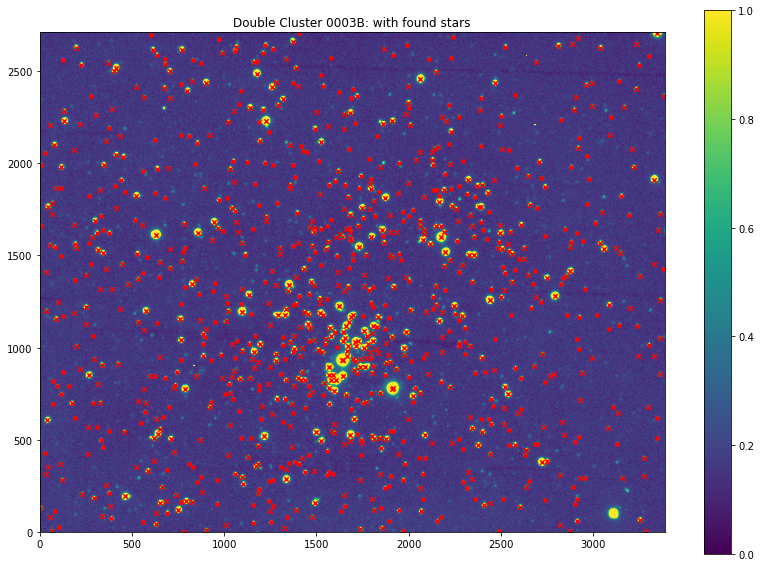

In [18]:
fig = plt.figure(figsize=(14,10))
plt.imshow(subimB,vmin=-100,vmax=500, origin="lower")
plt.scatter(sourcesB['xcentroid'],sourcesB['ycentroid'],c='r',marker='x', s=20)
plt.colorbar()
plt.title("Double Cluster 0003B: with found stars")
plt.show()

## 6) Aperture photometry

Perform aperture photometry for the two catalogs of detected sources using ``bozepy.phot.aperphot()``.  Use an aperture of radius 6 pixels, inner background radius of 10 pixels and outer background radius of 20 pixels.

In [19]:
from bozepy import phot
fluxesB = phot.aperphot(imB, sourcesB, rap=6., rin=10.0, rout=20.0)
del fluxesB['mag']

fluxesR = phot.aperphot(imR, sourcesR, rap=6., rin=10.0, rout=20.0)
del fluxesR['mag']

b) Convert the fluxes to magnitudes with a constant offset of 25.0.

c) Add these to a new ``mag`` column in the ``phot`` catalogs.

In [20]:
fluxesB['mag'] = -2.5*np.log10(fluxesB['aperture_sum'])+25
fluxesR['mag'] = -2.5*np.log10(fluxesR['aperture_sum'])+25

## 7) WCS correction:

Image ``DoubleCluster-0003B.fit`` has an initial WCS in the header, but it has a small offset.  The star at X=465 and Y=194 is known to have the coordinates RA=34.927769, DEC=56.979407.  Use this information to fix the WCS (*HINT: You want to modify the CRVAL and CRPIX values.  Astropy WCS also seems to prefer setting both values of CRVAL or CRPIX at time by giving it a two-element list, rather than one at a time*).

In [21]:
from astropy.wcs import WCS
w = WCS(headB)
w.wcs.crval, w.wcs.crpix = [[34.927769,56.979407],[465, 194]]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 8) Gaia catalog. Plot CMD.

Load the provided ``DoubleCluster_gaiadr2.fits`` Gaia DR2 catalog.  Plot the G vs. Bp-Rp color-magnitude diagram (the columns are ``PHOT_XX_MEAN_MAG``).  Make sure that brighter objects are at the top.

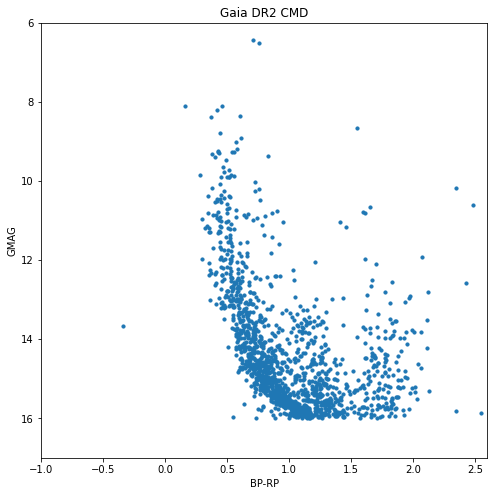

In [22]:
data = fits.getdata(f'{path}DoubleCluster_gaiadr2.fits')

fig = plt.figure(figsize=(8,8))
plt.scatter(data['PHOT_BP_MEAN_MAG']-data['PHOT_RP_MEAN_MAG'],data['PHOT_G_MEAN_MAG'],s=10)
plt.xlabel('BP-RP')
plt.ylabel('GMAG')
plt.title('Gaia DR2 CMD')
plt.xlim(-1,2.6)
plt.ylim(17,6)
plt.show()

## 9) Calibrating magnitudes with Gaia.

a) Use the WCS that you corrected above to calculate X/Y positions for the Gaia stars.

b) Plot the image and your detected sources on top.

c) Plot the Gaia sources on top as well (using a different symbol/color).  

d) Pick out **one** star that is in your detected sources and in Gaia.  It might help to zoom into a smaller region that has at least roughly 10 stars.  Figure out the rough X/Y values and use ``np.where()`` to select the relevant row from each catalog.

e) Now compare the Gaia BP magnitude to your ``DoubleCluster-0003B.fit`` magnitudes.  Figure out the offset between the two.  This is the zeropoint offset. Apply this offset to all of the stars in your catalog for this image (be sure to use the correct sign).

f) Do the same for ``DoubleCluster-0003R.fit`` and compare to the Gaia RP magnitudes.

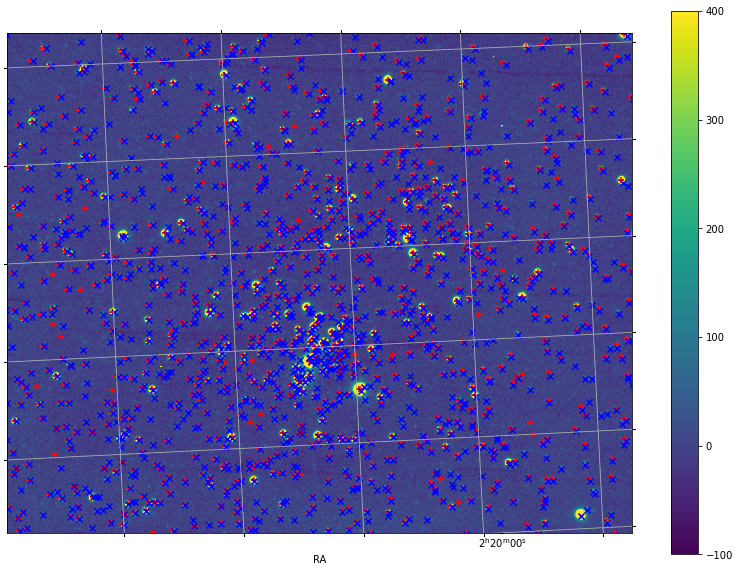

In [23]:
# %matplotlib notebook
%matplotlib inline

fig = plt.figure(figsize=(14, 10))
fig.add_subplot(111, projection=w)
plt.scatter(sourcesB['xcentroid'],sourcesB['ycentroid'],c='r',marker='+')
plt.scatter(w.wcs_world2pix(data['RA'], data['DEC'], 1)[0],w.wcs_world2pix(data['RA'], data['DEC'], 0)[1], c='b', marker='x')
plt.imshow(subimB,vmin=-100,vmax=400, origin="lower")
plt.grid(True)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()

# from sources: [RA: 2536, Dec: 747]
# from Gaia: [RA: 2541, 736]
d = w.wcs_world2pix(data['RA'], data['DEC'], 0)
ra, dec = d[0], d[1]
np.where((2530<d[0]) & (d[0]<2550) & (730<d[1]) & (d[1]<740))
offset = float(data[np.where((2530<d[0]) & (d[0]<2550) & (730<d[1]) & (d[1]<740))]['PHOT_BP_MEAN_MAG'] - \
    sourcesB[np.where((2530<sourcesB['xcentroid']) & (sourcesB['xcentroid']<2540) & (740<sourcesB['ycentroid']) & (sourcesB['ycentroid']<750))]['mag'])
sourcesB['mag'] += offset

Normally the axes just work for me, but this time they decided to throw a fit. I don't have the energy to fight with it today, so just use your imagination...


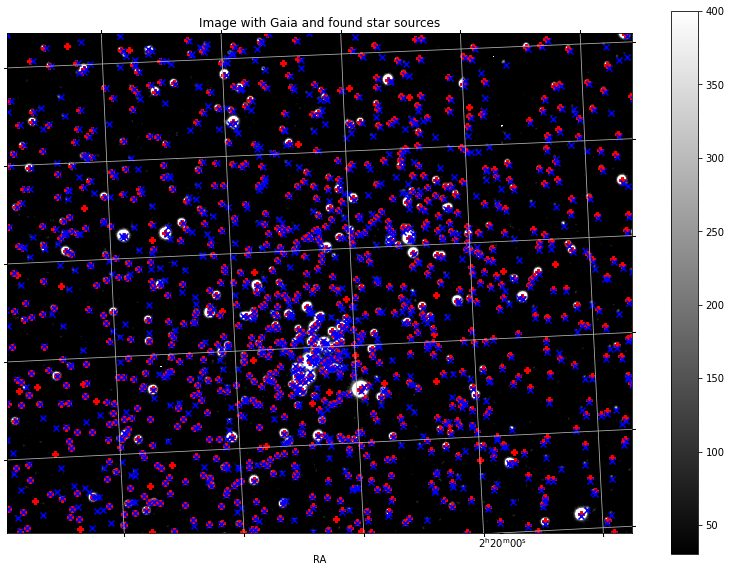

In [24]:
# %matplotlib notebook
%matplotlib inline

primt("Normally the axes just work for me, but this time they decided to throw a fit. I don't have the energy to fight with it today, so just use your imagination...")

fig = plt.figure(figsize=(14, 10))
fig.add_subplot(111, projection=w)
plt.scatter(sourcesR['xcentroid'],sourcesR['ycentroid'],c='r',marker='P')
plt.scatter(w.wcs_world2pix(data['RA'], data['DEC'], 1)[0],w.wcs_world2pix(data['RA'], data['DEC'], 0)[1], c='blue', marker='x')
plt.imshow(subimR,vmin=30,vmax=400, origin="lower",cmap='gist_gray')
plt.grid(True)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.title("Image with Gaia and found star sources")
plt.show()

# from sources: [RA: 2536, Dec: 747]
# from Gaia: [RA: 2541, 736]
d = w.wcs_world2pix(data['RA'], data['DEC'], 0)
ra, dec = d[0], d[1]
np.where((2530<d[0]) & (d[0]<2550) & (730<d[1]) & (d[1]<740))
offset = float(data[np.where((2530<d[0]) & (d[0]<2550) & (730<d[1]) & (d[1]<740))]['PHOT_RP_MEAN_MAG'] - \
    sourcesR[np.where((2530<sourcesR['xcentroid']) & (sourcesR['xcentroid']<2540) & (740<sourcesR['ycentroid']) & (sourcesR['ycentroid']<750))]['mag'])
sourcesR['mag'] += offset

## 10) Crossmatching

Crossmatch the sources in your two photometry catalogs using the ``xcenter`` and ``ycenter`` values and the ``dlnpyutils.coords.xmatch()`` function.

a) Use ``xmatch()`` to crossmatch the two catalogs.

b) Use the two index lists to create two new "matched" catalogs.

In [25]:
from dlnpyutils import coords

d = w.wcs_pix2world(sourcesB['xcentroid'], sourcesB['ycentroid'], 0)
raB, decB = d[0], d[1]
d = w.wcs_pix2world(sourcesR['xcentroid'], sourcesR['ycentroid'], 0)
raR, decR = d[0], d[1]
cords = coords.xmatch(raB, decB, raR, decR)

In [26]:
sourcesB[cords[0]]['mag']
all_mags = Table()
all_mags['MAG_3B'] = sourcesB[cords[0]]['mag']
all_mags['MAG_3R'] = sourcesR[cords[1]]['mag']

## 11) Color Magnitude Diagram.

Make a color magnitude diagram using your matched catalogs and calibrated photometry.  MAG_3R vs. MAG_3B - MAG_3R.  Make sure the brighter stars are at the top.

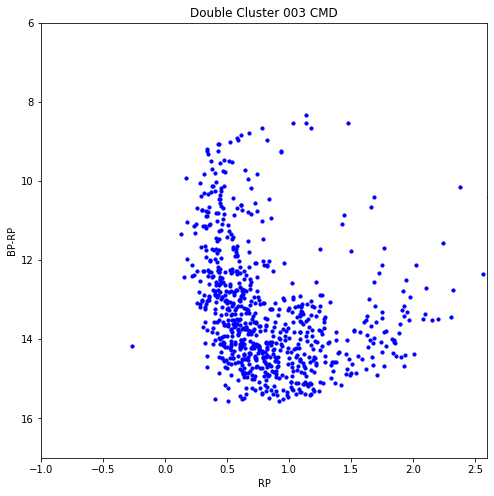

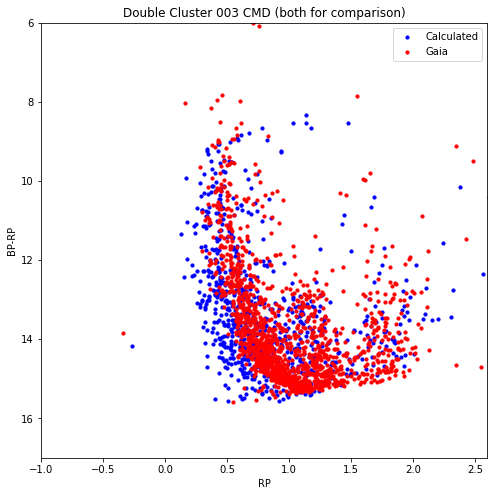

In [27]:
fig = plt.figure(figsize=(8,8))
plt.scatter(all_mags['MAG_3B']-all_mags['MAG_3R'], all_mags['MAG_3R'],s=10, c='b')
plt.ylabel('BP-RP')
plt.xlabel('RP')
plt.title('Double Cluster 003 CMD')
plt.xlim(-1,2.6)
plt.ylim(17,6)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.scatter(all_mags['MAG_3B']-all_mags['MAG_3R'], all_mags['MAG_3R'],s=10, c='b', label='Calculated')
plt.scatter(data['PHOT_BP_MEAN_MAG']-data['PHOT_RP_MEAN_MAG'],data['PHOT_RP_MEAN_MAG'],s=10, c='r', label='Gaia')

plt.ylabel('BP-RP')
plt.xlabel('RP')
plt.title('Double Cluster 003 CMD (both for comparison)')
plt.xlim(-1,2.6)
plt.ylim(17,6)
plt.legend(loc="upper right")
plt.show()